# Exercise 4

In [1]:
import numpy as np
import matplotlib.pyplot as plt

from util_functions import *

In [2]:
# Ex 4.1
# Find projection matrix and projections
f = 1000
resolution = (1920, 1080)
principal_point = (resolution[0]/2, resolution[1]/2)
K = camera_intrinsic(f, principal_point)
K

array([[1000.,    0.,  960.],
       [   0., 1000.,  540.],
       [   0.,    0.,    1.]])

In [3]:
R = np.array([[np.sqrt(0.5), -np.sqrt(0.5), 0],
              [np.sqrt(0.5), np.sqrt(0.5), 0],
              [0, 0, 1]])
t = np.array([[0, 0, 10]]).T
P = projection_matrix(K, R, t)
print(P)

[[ 7.07106781e+02 -7.07106781e+02  9.60000000e+02  9.60000000e+03]
 [ 7.07106781e+02  7.07106781e+02  5.40000000e+02  5.40000000e+03]
 [ 0.00000000e+00  0.00000000e+00  1.00000000e+00  1.00000000e+01]]


In [4]:
Q = np.array([(x,y,z) for x in [0,1] for y in [0,1] for z in [0,1]]).T  # 3 x n
Q

array([[0, 0, 0, 0, 1, 1, 1, 1],
       [0, 0, 1, 1, 0, 0, 1, 1],
       [0, 1, 0, 1, 0, 1, 0, 1]])

In [5]:
q = project_points(K, R, t, Q)
with np.printoptions(precision=3):
    print(q)

[[ 960.     960.     889.289  895.718 1030.711 1024.282  960.     960.   ]
 [ 540.     540.     610.711  604.282  610.711  604.282  681.421  668.565]]


In [31]:
# Ex 4.2
# Estimate projection matrix
def pest(Q,q):
    '''
    Estimate projection matrix using direct linear transformation.

    Q: 3 x n array of 3D points
    q: 2 x n array of 2D points
    '''
    if Q.shape[0] != 3:
        raise ValueError('Q must be a 3 x n array of 3D points')
    if q.shape[0] != 2:
        raise ValueError('q must be a 2 x n array of 2D points')
    
    q = PiInv(q)    # 3 x n
    Q = PiInv(Q)    # 4 x n
    n = Q.shape[1]  # number of points
    B = []
    for i in range(n):
        Qi = Q[:,i]
        qi = q[:,i]
        # Xi, Yi, Zi = Qi
        # xi, yi, _ = qi
        # Bi = np.array([[0, -Xi, Xi*yi, 0, -Yi, Yi*yi, 0, -Zi, Zi*yi, 0, -1, yi],
        #                [Xi, 0, -Xi*xi, Yi, 0, -Yi*xi, Zi, 0, -Zi*xi, 1, 0, -xi],
        #                [-Xi*yi, Xi*xi, 0, -Yi*yi, Yi*xi, 0, -Zi*yi, Zi*xi, 0, -yi, xi, 0]])
        Bi = np.kron(Qi, CrossOp(qi))
        B.append(Bi)
    B = np.array(B).reshape(3*n, 12)
    U, S, Vt = np.linalg.svd(B)
    P = Vt[-1].reshape(4,3)
    P = P.T 
    return P

P_est = pest(Q,q)
# print("True P:\n", P)
print("Estimated P:\n", P_est)

# Compute RMSE
q_est = P_est @ PiInv(Q)
# print(q_est)
se = (q_est[:2]/q_est[-1] - q)**2
rmse = np.sqrt(np.mean((se)))
print("RMSE: ", rmse)   # should be close to 0

Estimated P:
 [[ 6.33639514e-02 -6.33639514e-02  8.60257530e-02  8.60257530e-01]
 [ 6.33639514e-02  6.33639514e-02  4.83894861e-02  4.83894861e-01]
 [-1.77700736e-16  1.82586422e-17  8.96101594e-05  8.96101594e-04]]
RMSE:  1.4737199822890567e-10


In [37]:
def pest_norm(Q,q):
    '''
    Estimate projection matrix using direct linear transformation.

    Q: 3 x n array of 3D points
    q: 2 x n array of 2D points
    '''
    if Q.shape[0] != 3:
        raise ValueError('Q must be a 3 x n array of 3D points')
    if q.shape[0] != 2:
        raise ValueError('q must be a 2 x n array of 2D points')
    
    normalize = True
    if normalize:
        q, T = normalize2d(q)

    q = PiInv(q)    # 3 x n
    Q = PiInv(Q)    # 4 x n
    n = Q.shape[1]  # number of points
    B = []
    for i in range(n):
        Qi = Q[:,i]
        qi = q[:,i]
        Bi = np.kron(Qi, CrossOp(qi))
        B.append(Bi)
    B = np.array(B).reshape(3*n, 12)
    U, S, Vt = np.linalg.svd(B)
    P = Vt[-1].reshape(4,3)
    P = P.T
    return P

In [38]:
P_est = pest_norm(Q,q)
q_est = P_est @ PiInv(Q)

# Compute RMSE
se = (q_est[:2]/q_est[-1] - q)**2
rmse = np.sqrt(np.mean((se)))
print("RMSE: ", rmse)
# BUG: Normalizing the points should improve reprojection error slightly.

RMSE:  804.6860166928669


In [8]:
# Ex 4.3
def checkerboard_points(n, m):
    '''
    Generate 3D points of a checkerboard with n x m squares.
    '''
    points = np.array([(i-(n-1)/2, j-(m-1)/2, 0)
                      for i in range(n) for j in range(m)]).T
    return points


Qcb = checkerboard_points(5, 4)
print(Qcb.shape)
print(Qcb)

(3, 20)
[[-2.  -2.  -2.  -2.  -1.  -1.  -1.  -1.   0.   0.   0.   0.   1.   1.
   1.   1.   2.   2.   2.   2. ]
 [-1.5 -0.5  0.5  1.5 -1.5 -0.5  0.5  1.5 -1.5 -0.5  0.5  1.5 -1.5 -0.5
   0.5  1.5 -1.5 -0.5  0.5  1.5]
 [ 0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.
   0.   0.   0.   0.   0.   0. ]]


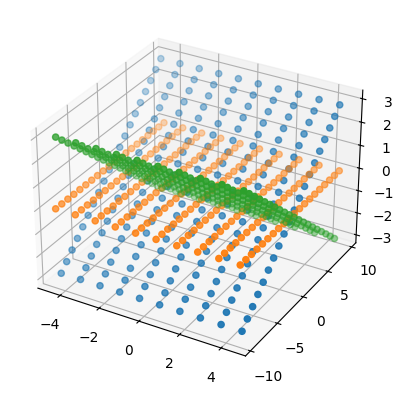

In [12]:
# Ex 4.4
from scipy.spatial.transform import Rotation

Ra = Rotation.from_euler('xyz', [np.pi/10,0,0]).as_matrix()
Rb = Rotation.from_euler('xyz', [0,0,0]).as_matrix()
Rc = Rotation.from_euler('xyz', [-np.pi/10,0,0]).as_matrix()

Q_omega = checkerboard_points(10,20)
Qa = Ra @ Q_omega
Qb = Rb @ Q_omega
Qc = Rc @ Q_omega

fig = plt.figure()
ax = plt.axes(projection ='3d')
ax.scatter(Qa[0,:], Qa[1,:], Qa[2,:])
ax.scatter(Qb[0,:], Qb[1,:], Qb[2,:])
ax.scatter(Qc[0,:], Qc[1,:], Qc[2,:])
plt.show()

In [44]:
# Ex 4.5
# TODO
def estimate_homographies(Q_omega, qs):
    '''
    Q_omega : 3 x (nxm) array of untransformed 3D points
    qs : list of arrays corresponding to each view
    '''

qs = [q1, q2, q3]
H = estimate_homographies(Q_omega, [q1, q2, q3])

3.141592653589793

In [21]:


def form_vi(H,a,b):
    '''
    Form 1x6 vector vi from H and indices alpha and beta.
    '''
    vi = np.array([H[0,a]*H[0,b], H[0,a]*H[1,b] + H[1,a]*H[0,b], H[1,a]*H[1,b], 
                   H[2,a]*H[0,b] + H[0,a]*H[2,b], H[2,a]*H[1,b] + H[1,a]*H[2,b], H[2,a]*H[2,b]])
    return vi

def pest_zhang(Q,q):
    '''
    Estimate projection matrix using Zhang's method.

    Q: 3D points, 3 x n
    q: 2D points, 2 x n
    '''
    q1 = q
    q2 = Q[0:2] # assume z=0 and ignore it
    n = 1       # number of images
    V = []

    # Create constraints in matrix form
    for _ in range(n):
        H = hest(q1, q2)
        vi_11 = form_vi(H, 1, 1)
        vi_12 = form_vi(H, 1, 2)
        vi_22 = form_vi(H, 2, 2)
        v = np.array([[vi_12], [vi_11 - vi_22]])
        print(v.shape)
        V.append(v)
    V = np.array(V)
    print(V.shape)
    
    U, S, b = np.linalg.svd(V)
    # print(b)

pest(Q, q)


(2, 1, 6)
(1, 2, 1, 6)
(1, 2, 6, 6)
